# 1. Import & Data

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, metrics, pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
train = pd.read_csv("/content/drive/MyDrive/data/train_NLP.csv")
test = pd.read_csv("/content/drive/MyDrive/data/test_NLP.csv")

In [5]:
print(f"train shape: {train.shape}")
print(f"test shape: {test.shape}")

train shape: (7613, 5)
test shape: (3263, 4)


In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 2. EDA

In [8]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

## Exploring 'target' column

In [10]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<ipython-input-13-f15522fbd7b3>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = train['target'].value_counts().index, y = train['target'].value_counts(), palette = 'rocket')


<Axes: xlabel='target', ylabel='count'>

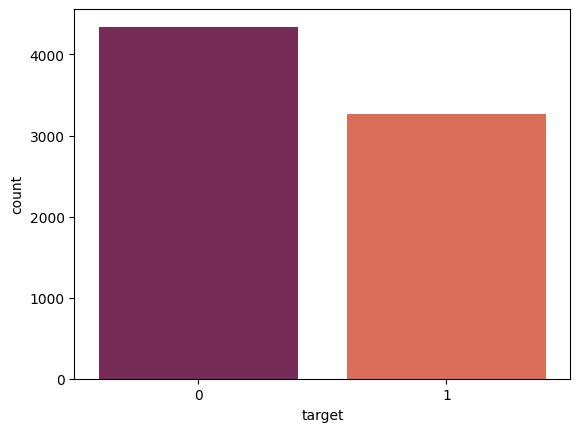

In [13]:
sns.barplot(x = train['target'].value_counts().index, y = train['target'].value_counts(), palette = 'rocket')

In [15]:
disaster_tweets = train[train['target'] == 1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [16]:
non_disaster_tweets = train[train['target'] == 0]['text']
non_disaster_tweets.values[1]

'I love fruits'

## Exploring 'keyword' column

<Axes: xlabel='count', ylabel='keyword'>

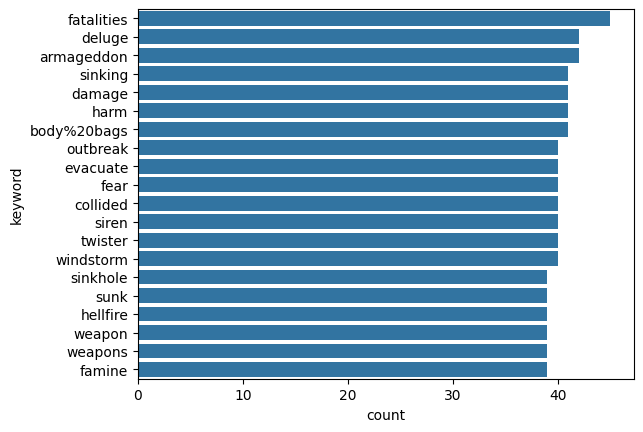

In [17]:
sns.barplot(y = train['keyword'].value_counts()[:20].index, x = train['keyword'].value_counts()[:20], orient = 'h')

In [18]:
# text 열의 문자열이 'disaster'을 포함하는지 확인한다.
# 결측치는 포함하지 않도록 한다.
# case (대소문자)를 구분하지 않는다.
# 만들어진 데이터 프레임의 target 열의 카테고리별 데이터 수를 센다.
train.loc[train['text'].str.contains('disaster',
                                     na = False,
                                     case = False)].target.value_counts()

target
1    102
0     40
Name: count, dtype: int64

## Exploring 'location' column

<Axes: xlabel='count', ylabel='location'>

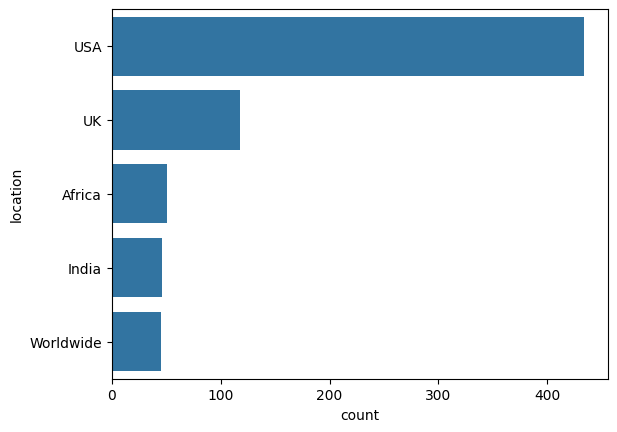

In [22]:
# replacing ambiguous locations anme wiwth Standard name

train['location'].replace({"United States":"USA",
                           "New York":"USA",
                           "London":"UK",
                           "Los Angeles, CA":"USA",
                           "Washington":"USA",
                           "California": "USA",
                           "Chicago, IL":"USA",
                           "Chicago":"USA",
                           "New York, NY": "USA",
                           "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',"New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y = train['location'].value_counts()[:5].index, x = train['location'].value_counts()[:5], orient = 'h')

# 3. Data preprocessing

## 1. Data cleaning
>unify it as either lower case or upper case

>removing noise: abnormal punctuation, numerical values, common meaningless text

>Tokenization: convert text strings to tokens

>Stopword removal: words that appear frequently but not that useful in conveying meaning ex) this, a, the

After tokenization, we have to implement further data cleaning

>Stemming: 단어의 접미사나 어미를 잘라내 어간(stem)으로 변환하는 과정. 종종 실제 단어가 아니라 어간으로 변환될 수 있다.

>Lemmatization: 단어의 문법과 품사를 고려해 정확한 기본형으로 변환하는 과정. 항상 실제 단어로 변환된다.

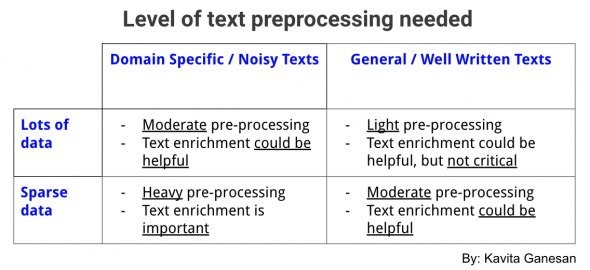

In [23]:
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [25]:
def clean_text(text):

    text = text.lower() # 소문자 변환
    text = re.sub('\[.*?\]', '', text) # text에서 대괄호 안의 문자열들을 없앰. \[와 \]는 대괄호를 찾음
    text = re.sub('https://\S+|www\.\S+', '', text) # text에서 'https://나 www\.로 시작하는 URL을 없앰
    text = re.sub('<.*?>+', '', text) # text에서 html 태그를 제거
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # text의 .,!"등을 삭제
    text = re.sub('\n', '', text) # 줄바꿈 문자 삭제
    text = re.sub('\w*\d\w*', '', text) # 숫자가 포함된 단어를 제거. \w*는 숫자가 반복되는 패턴을 찾음

    return text

train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Text(0.5, 1.0, 'Non Disaster Tweets')

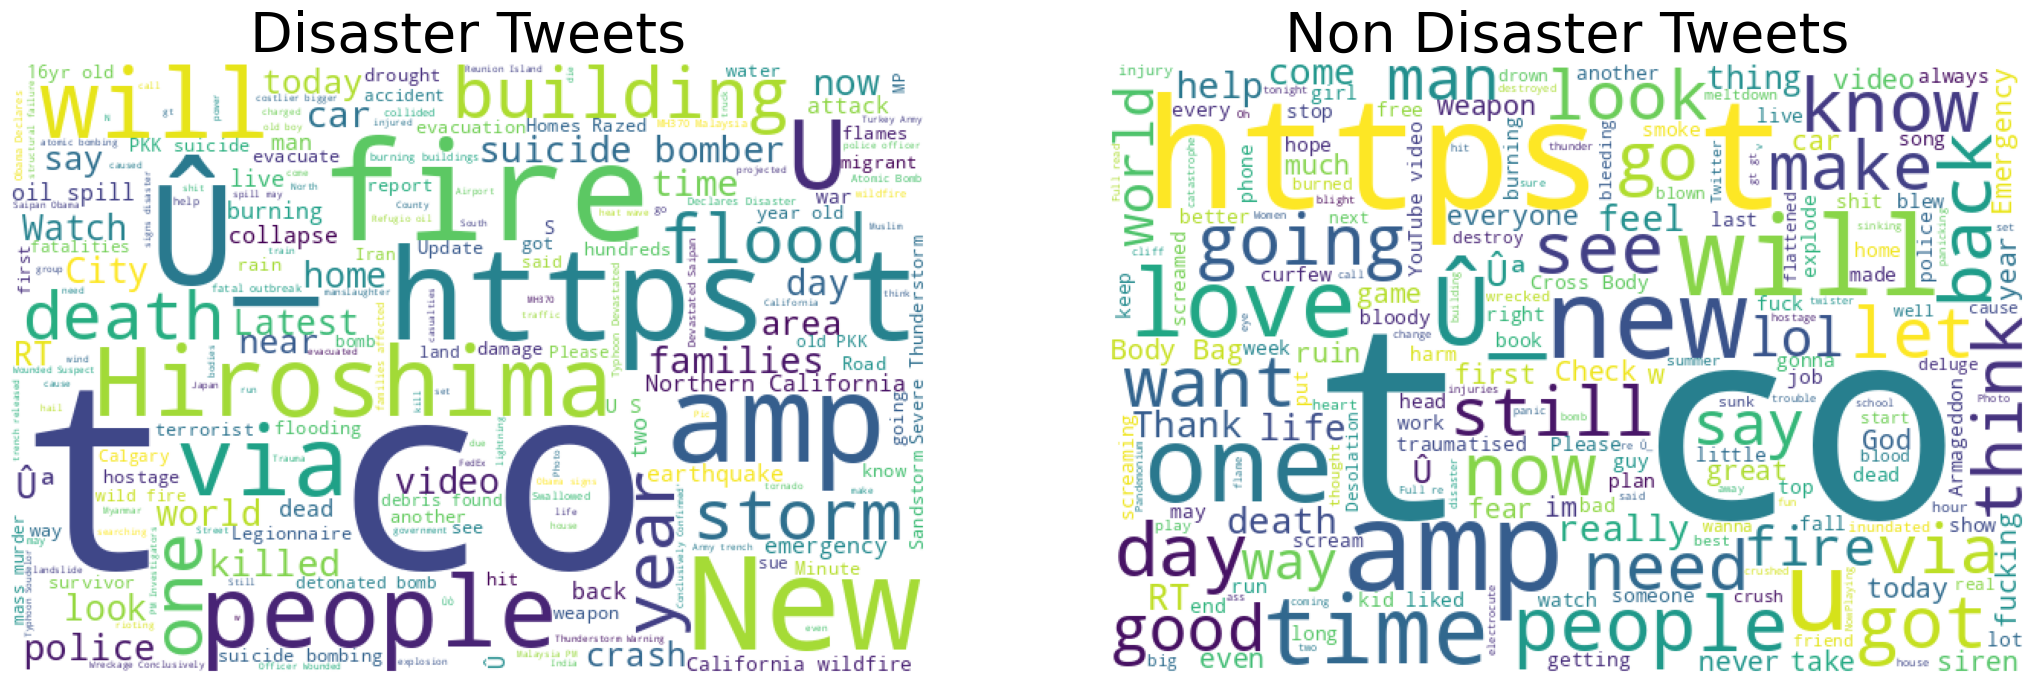

In [26]:
# create word clouds

from wordcloud import WordCloud

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (26, 8))

wordcloud1 = WordCloud(background_color = 'white', width = 600, height = 400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets', fontsize = 40)

wordcloud2 = WordCloud(background_color = 'white', width = 600, height = 400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets', fontsize = 40)

## 2. Tokenization

In [27]:
text = "Are you coming, aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer() # 공백을 기준으로
tokenizer2 = nltk.tokenize.TreebankWordTokenizer() # 구두점을 별도의 토큰으로 분리
tokenizer3 = nltk.tokenize.WordPunctTokenizer() # 단어와 구두점을 분리해 각각의 토큰으로 분리
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+') # 알파벳과 숫자만 추출

print('Example Text:', text)
print('----------------------------------------')
print(f"Tokenization by whitespace -: {tokenizer1.tokenize(text)}")
print(f"Tokenization by treebankspace -: {tokenizer2.tokenize(text)}")
print(f"Tokenization by wordpunctspace -: {tokenizer3.tokenize(text)}")
print(f"Tokenization by regexspace -: {tokenizer4.tokenize(text)}")

Example Text: Are you coming, aren't you
----------------------------------------
Tokenization by whitespace -: ['Are', 'you', 'coming,', "aren't", 'you']
Tokenization by treebankspace -: ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by wordpunctspace -: ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regexspace -: ['Are', 'you', 'coming', 'aren', 't', 'you']


In [30]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))

train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

## 3. Stopwords removal

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
def remove_stopwords(text):

    words = [w for w in text if w not in stopwords.words('english')]

    return words

train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


## 4. Token normalization

A process of converting tokens to their base forms. Stemming은 wolves -> wolv처럼 어근을 제거한다. Lemmatization은 wolves -> wolf처럼 기본형으로 바꾼다. 그러나 stemming과 lemmatization이 항상 성능을 향상시키는 것은 아니고, problem by problem이다.

In [39]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [41]:
# example

text = 'feet cats wolves talked'

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text) # text를 토큰으로 쪼갬

print("Original sentence:", " ".join(token for token in tokens))

stemmer = nltk.stem.PorterStemmer()
# " " 공백을 사이에 두고 token들을 합침
print("Stemming the sentence :", " ".join(stemmer.stem(token) for token in tokens))

lemmatizer = nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentece:", " ".join(lemmatizer.lemmatize(token) for token in tokens))

Original sentence: feet cats wolves talked
Stemming the sentence : feet cat wolv talk
Lemmatizing the sentece: foot cat wolf talked


In [42]:
# after preprocessing, combine tokens into sentence
def combine_text(list_of_text):

    combined_text = ' '.join(list_of_text)

    return combined_text

train['text'] = train['text'].apply(lambda x: combine_text(x))
test['text'] = test['text'].apply(lambda x: combine_text(x))

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [43]:
# put it all together

def text_preprocessing(text):

    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') # tokenizer 생성
    nopunc = clean_text(text) # 대괄호, URL, html, 구두점, 줄바꿈 문자, 숫자 포함 단어 제거
    tokenized_text = tokenizer.tokenize(nopunc) # tokenization
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')] # stopwords 제거
    combined_text = ' '.join(remove_stopwords) # 토큰들을 합침

    return combined_text

# 4. Transforming tokens to a vector

## 1. Bag-Of-Words
Bag-Of-Words is a representation of text that describes the occurrence of words within a document. It concerns only about the occurrence of unique words, not the order of words. We will use Countvectorizer. Countvectorizer converts a collection of text documents to a matrix of token counts.
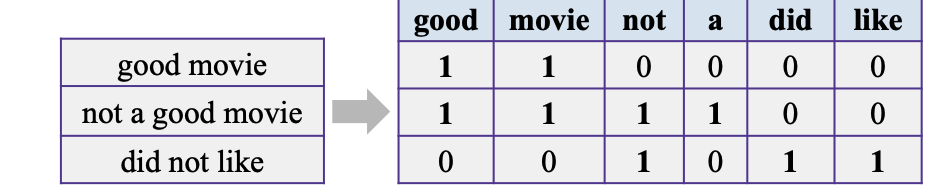


In [44]:
count_vectorizer = CountVectorizer()
# text에 맞춰 count_vectorizer를 fit하고 train['text']를 fit한 결과를 사용해 변환함
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.fit_transform(test['text'])

print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


## 2. TFIDF features

The problem of Bag-Of-Word is that highly frequent words start to dominate the document without enough informational content. Also, it will give more weight to longer documents than shorter documents.


One approach is to rescale the frequency of words by how often they appear in all documents so that the score for frequent words like "the" that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency.

* Term Frequency is a scoring of the frequency of the word in the current document.
* Inverse Document Frequency is a scoring of how rare the word is across documents.

-> 단어가 한 문서 내에서 얼마나 빈번하게 쓰이느냐 & 단어가 전체 문서에 걸쳐 얼마나 빈번하게 등장하느냐

In [49]:
# min_df = 2: 단어가 최소 두 문서에 포함되어야 그 단어를 벡터화에 포함. 너무 드물게 등장하는 단어는 noise로 분류.
# max_df = 0.5: 단어가 전체 문서 50% 이하의 문서에서 등장해야 그 단어를 벡터화에 포함. 너무 많이 등장하는 단어(stopwords)를 제거해 유용한 특징을 추출.
# ngram_range = (1, 2): 단어뿐 아니라 단어쌍도 포함. 더 풍부한 표현 가능.
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range = (1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.fit_transform(test['text'])

# 5. Building a text classification model

## 1. Logistic regression classifier

In [45]:
clf = LogisticRegression(C = 1.0)
# cross validation: clf 분류기로 X = train_vectors, y = train['target'], 5-cross validation, scoring using f1
scores = model_selection.cross_val_score(clf, train_vectors, train['target'], cv = 5, scoring = "f1")
scores

array([0.59865255, 0.49740035, 0.5682968 , 0.5588785 , 0.68834259])

In [46]:
# 분류기를 데이터에 fit
clf.fit(train_vectors, train['target'])

LogisticRegression()

In [50]:
clf_tfidf = LogisticRegression(C = 1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train['target'], cv = 5, scoring = "f1")
scores

array([0.57606491, 0.49486461, 0.54193548, 0.46458333, 0.64648264])

In this case, CountVectorizer outperforms TFIDF.

## 2. Naive Bayes Classifier

In [51]:
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train['target'], cv = 5, scoring = "f1")
scores

array([0.63149079, 0.60662824, 0.68526466, 0.64330218, 0.72603671])

In [52]:
clf_NB.fit(train_vectors, train['target'])

MultinomialNB()

In [53]:
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train['target'], cv = 5, scoring = "f1")
scores

array([0.57590597, 0.56840247, 0.61135371, 0.59464451, 0.7393745 ])

In [54]:
clf_NB_TFIDF.fit(train_tfidf, train['target'])

MultinomialNB()

## 3. XGBoost

In [55]:
clf_xgb = XGBClassifier(max_depth = 7,
                        n_estimators = 200,
                        colsample_bytree = 0.8,
                        subsample = 0.8,
                        nthread = 10,
                        learning_rate = 0.1)

scores = model_selection.cross_val_score(clf_xgb, train_vectors, train['target'], cv = 5, scoring = "f1")
scores

array([0.48200654, 0.36801541, 0.43807763, 0.39381443, 0.52952381])

In [56]:
clf_xgb_TFIDF = XGBClassifier(max_depth = 7,
                        n_estimators = 200,
                        colsample_bytree = 0.8,
                        subsample = 0.8,
                        nthread = 10,
                        learning_rate = 0.1)

scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train['target'], cv = 5, scoring = "f1")
scores

array([0.49002217, 0.3493014 , 0.43708609, 0.41408751, 0.53751187])